# Part 1: Visual Document Search with ColQwen and Elasticsearch `rank_vectors`

This notebook demonstrates how to reproduce and enhance the concepts from the Elastic Search Labs blog post '[Searching complex documents with ColPali](https://www.elastic.co/search-labs/blog/elastiacsearch-colpali-document-search)'.

**Key Enhancements:**

1.  **Model Upgrade**: We use the **`tsystems/colqwen2.5-3b-multilingual-v1.0`** model, a top-performing model on the ViDoRe benchmark.
2.  **Real-world Dataset**: We use sample images from the **RVL-CDIP** dataset to demonstrate capabilities on complex, real-world documents.
3.  **Robust Connection Logic**: The connection logic automatically detects whether the environment variable specifies a **Cloud ID** or a **Host URL**, ensuring a stable connection.

### Step 0: Setup Environment

**[EN]** Install the necessary libraries.<br>
**[KR]** 필요한 라이브러리를 설치합니다.

In [1]:
!pip install -q "git+https://github.com/illuin-tech/colpali.git"
!pip install -q "transformers>=4.41.0" accelerate Pillow elasticsearch python-dotenv tqdm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


### Step 1: Import Libraries and Set Environment Variables

**[EN]** Import necessary libraries and load environment variables from the `elastic.env` file.<br>
**[KR]** 필요한 라이브러리를 임포트하고, `elastic.env` 파일에서 환경 변수를 로드합니다.

In [2]:
import torch
import os
import glob
import base64
from io import BytesIO
from tqdm.notebook import tqdm
from PIL import Image
from elasticsearch import Elasticsearch
from dotenv import load_dotenv
from IPython.display import display, HTML

dotenv_path = 'elastic.env'
load_dotenv(dotenv_path=dotenv_path)

ES_URL = os.getenv("ES_URL")
ES_API_KEY = os.getenv("ES_API_KEY")

if not ES_URL or not ES_API_KEY:
    raise ValueError(f"Please ensure '{dotenv_path}' contains ES_URL and ES_API_KEY.")

INDEX_NAME = "colqwen-rvlcdip-demo-part1"
VECTOR_FIELD_NAME = "colqwen_vectors"
SAMPLED_DATA_DIR = "samples"

### Step 2: Load the ColQwen Model

**[EN]** Load the `tsystems/colqwen2.5-3b-multilingual-v1.0` model and its processor.<br>
**[KR]** `tsystems/colqwen2.5-3b-multilingual-v1.0` 모델과 프로세서를 로드합니다.

In [3]:
from colpali_engine.models import ColQwen2_5, ColQwen2_5_Processor

device_map = "cpu"
if torch.backends.mps.is_available():
    device_map = "mps"
elif torch.cuda.is_available():
    device_map = "cuda:0"
print(f"Using device: {device_map}")

MODEL_NAME = "tsystems/colqwen2.5-3b-multilingual-v1.0"
model = ColQwen2_5.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if device_map != "cpu" else torch.float32,
    device_map=device_map
).eval()
processor = ColQwen2_5_Processor.from_pretrained(MODEL_NAME)
print(f"Model '{MODEL_NAME}' loaded successfully on device '{model.device}'.")

Using device: cuda:0


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


Model 'tsystems/colqwen2.5-3b-multilingual-v1.0' loaded successfully on device 'cuda:0'.


### Step 3: Load RVL-CDIP Sample Data

**[EN]** Load the list of RVL-CDIP sample image files from the `samples` directory.<br>
**[KR]** `samples` 디렉터리에서 RVL-CDIP 샘플 이미지 파일 목록을 가져옵니다.

In [4]:
if not os.path.exists(SAMPLED_DATA_DIR):
    raise FileNotFoundError(f"Sample data directory not found at '{SAMPLED_DATA_DIR}'. Please create it in the same directory as this notebook.")

image_paths = []
for category_dir in os.listdir(SAMPLED_DATA_DIR):
    full_category_path = os.path.join(SAMPLED_DATA_DIR, category_dir)
    if os.path.isdir(full_category_path):
        image_paths.extend(glob.glob(os.path.join(full_category_path, '*.*')))
print(f"Found {len(image_paths)} sample images.")

Found 1600 sample images.


### Step 4: Define Embedding Helper Functions

**[EN]** Define helper functions to generate multi-vector embeddings for document images and text queries.<br>
**[KR]** 문서 이미지와 텍스트 질의의 다중 벡터 임베딩을 생성하는 함수를 정의합니다.

In [5]:
def create_colqwen_document_vectors(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = processor.process_images([image]).to(model.device)
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.cpu().to(torch.float32).numpy().tolist()[0]
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

def create_colqwen_query_vectors(query_text):
    inputs = processor.process_queries([query_text]).to(model.device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.cpu().to(torch.float32).numpy().tolist()[0]

### Step 5 & Step 6 : Connect to Elasticsearch and Create an Index and Index the Data

**[EN]** Connect to Elasticsearch and create an index with a `rank_vectors` field and index the loaded sample images into Elasticsearch. <br>
**[KR]** Elasticsearch에 연결하고 `rank_vectors` 필드를 포함하는 인덱스를 생성한 후 로드된 샘플 이미지들을 Elasticsearch에 인덱싱합니다.

In [6]:
# This combined cell handles both index creation and document indexing
# to ensure data integrity based on the document count.

# --- Logic from original Step 5: Connect to Elasticsearch and Manage Index ---

# Automatically detect if ES_URL is a Cloud ID or a Host URL.
if ':' in ES_URL and not ES_URL.startswith('http'):
    # Connect using Cloud ID
    print("Connecting using Cloud ID...")
    es = Elasticsearch(
        cloud_id=ES_URL,
        api_key=ES_API_KEY,
        request_timeout=20
    )
else:
    # Connect using Host URL
    print("Connecting using Host URL...")
    es = Elasticsearch(
        hosts=[ES_URL],
        api_key=ES_API_KEY,
        request_timeout=20
    )

print(f"Connected to Elasticsearch version: {es.info()['version']['number']}")

# Define the index mapping
mapping = {
    "properties": {
        VECTOR_FIELD_NAME: {"type": "rank_vectors", "dims": 128},
        "image_path": {"type": "keyword"},
        "category": {"type": "keyword"}
    }
}

# --- Logic from original Step 6: Validate and Conditionally Index Documents ---

# Default to an invalid state to trigger re-indexing if checks fail.
is_index_valid = False

if es.indices.exists(index=INDEX_NAME):
    try:
        doc_count = es.count(index=INDEX_NAME)['count']
        print(f"Index '{INDEX_NAME}' already exists with {doc_count} documents.")
        if doc_count == 1600:
            is_index_valid = True
    except Exception as e:
        print(f"Could not retrieve document count for existing index. Will recreate. Error: {e}")
else:
    print(f"Index '{INDEX_NAME}' not found.")

# If the index is not valid (doesn't exist or has the wrong doc count),
# delete it, recreate it, and re-index all documents.
if not is_index_valid:
    print(f"Index state is not valid. Starting complete re-indexing process...")
    
    # 1. Delete the index if it exists, to ensure a clean state.
    if es.indices.exists(index=INDEX_NAME):
        print(f"Deleting existing index '{INDEX_NAME}'...")
        es.indices.delete(index=INDEX_NAME)
    
    # 2. Create a new, empty index with the correct mapping.
    print(f"Creating new index '{INDEX_NAME}'...")
    es.indices.create(index=INDEX_NAME, mappings=mapping)
    print(f"Index created successfully.")

    # 3. Index all 1600 documents.
    MAX_DOCS_TO_INDEX = 1600
    docs_to_index = image_paths[:min(len(image_paths), MAX_DOCS_TO_INDEX)]
    print(f"Indexing {len(docs_to_index)} documents...")

    for path in tqdm(docs_to_index, desc="Indexing Documents"):
        doc_id = os.path.splitext(os.path.basename(path))[0]
        category = os.path.basename(os.path.dirname(path))
        vectors = create_colqwen_document_vectors(path)
        
        if vectors:
            es_doc = {
                VECTOR_FIELD_NAME: vectors,
                "image_path": path,
                "category": category
            }
            es.index(index=INDEX_NAME, id=doc_id, document=es_doc)

    es.indices.refresh(index=INDEX_NAME)
    print("\nIndexing complete.")
else:
    print(f"Index '{INDEX_NAME}' is valid with 1600 documents. Skipping all steps.")

Connecting using Host URL...
Connected to Elasticsearch version: 8.11.0
Index 'colqwen-rvlcdip-demo-part1' already exists with 1600 documents.
Index 'colqwen-rvlcdip-demo-part1' is valid with 1600 documents. Skipping all steps.


### Step 7: Search and Visualize Results

**[EN]** Perform a search using `script_score` and new `maxSimDotProduct` function to calculate the similarity between our query and the image vectors in Elasticsearch and visualize the results.<br>
**[KR]** `script_score`와 새로 출시된 `maxSimDotProduct`를 사용하여 쿼리와 이미지 벡터 간의 유사성을 계산하여 검색을 수행하고  결과를 시각화합니다.


Searching for: 'Do you have a benefits policy change notice from HR?'
🚀 Search Latency: 9873.73 ms


ID: 515799417 Score: 10.1225 Category: letter,ID: 2058032023 Score: 9.8364 Category: specification,ID: 2501277134_2501277135 Score: 9.7451 Category: form,ID: 2072481221 Score: 9.7412 Category: email,ID: 2054630175 Score: 9.7293 Category: form

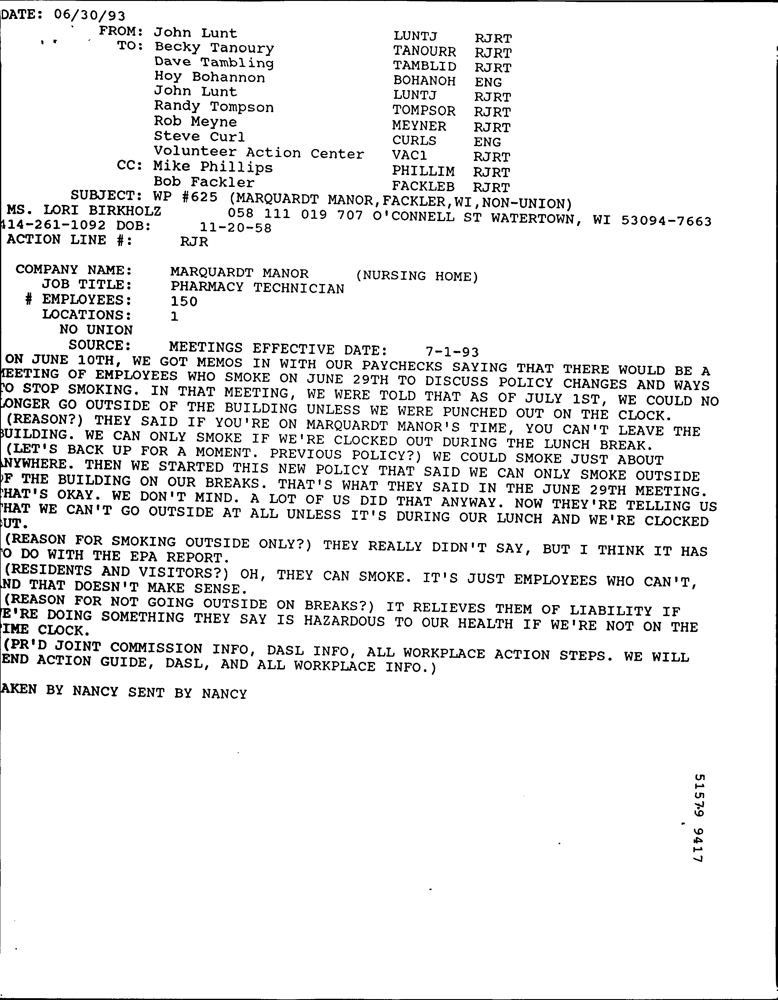
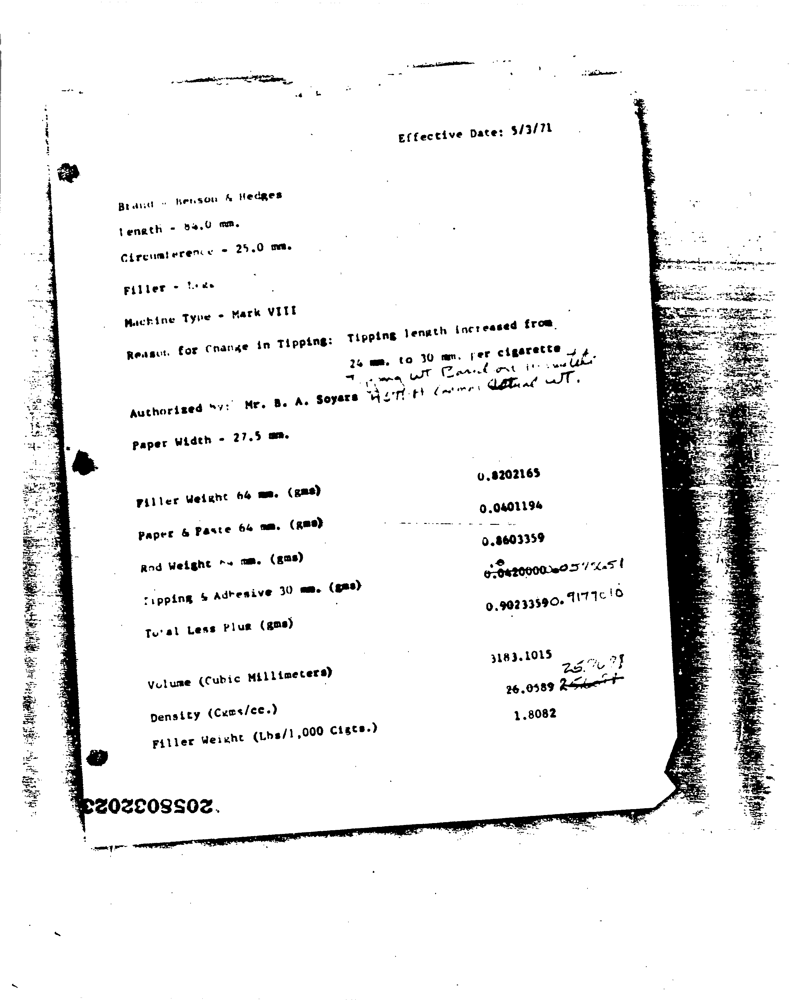
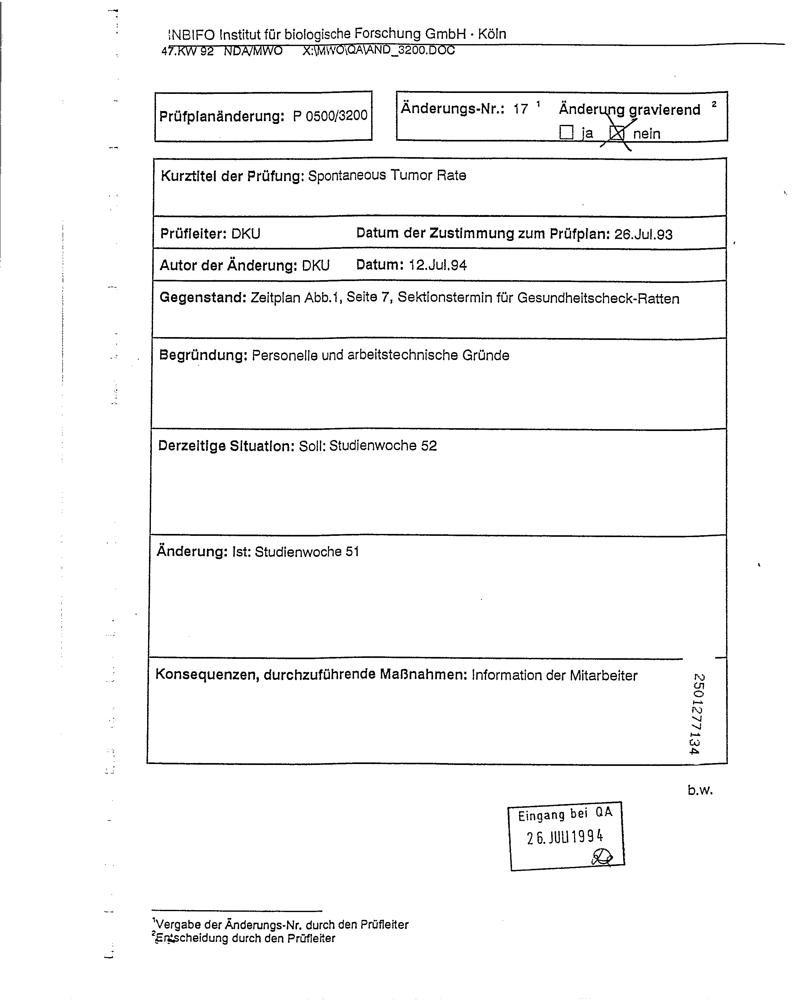
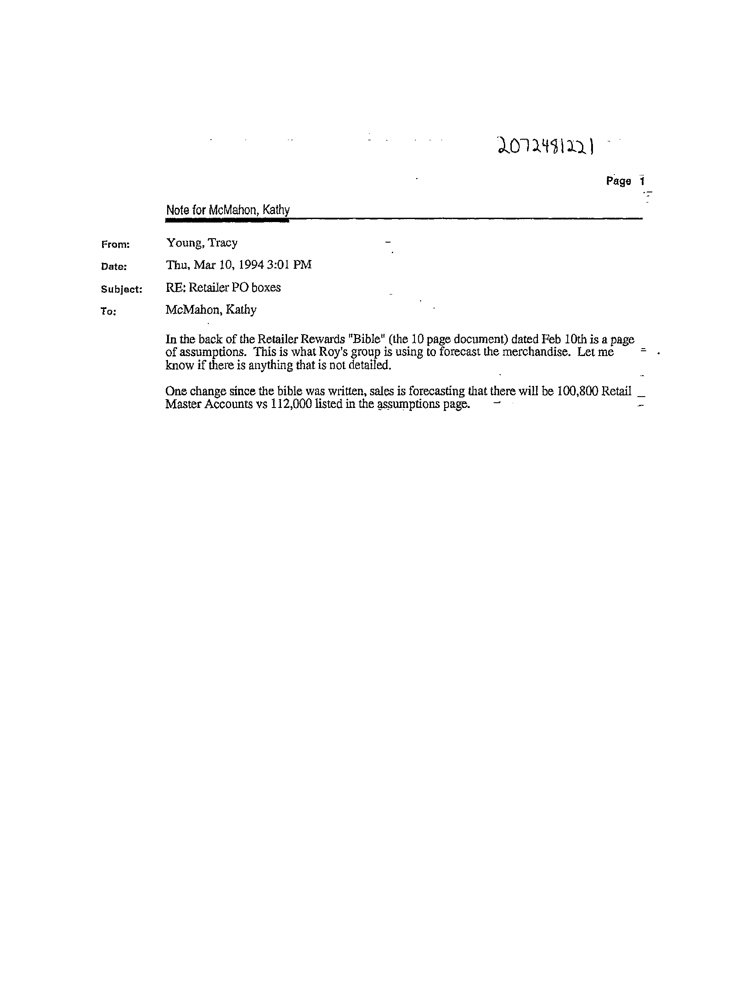
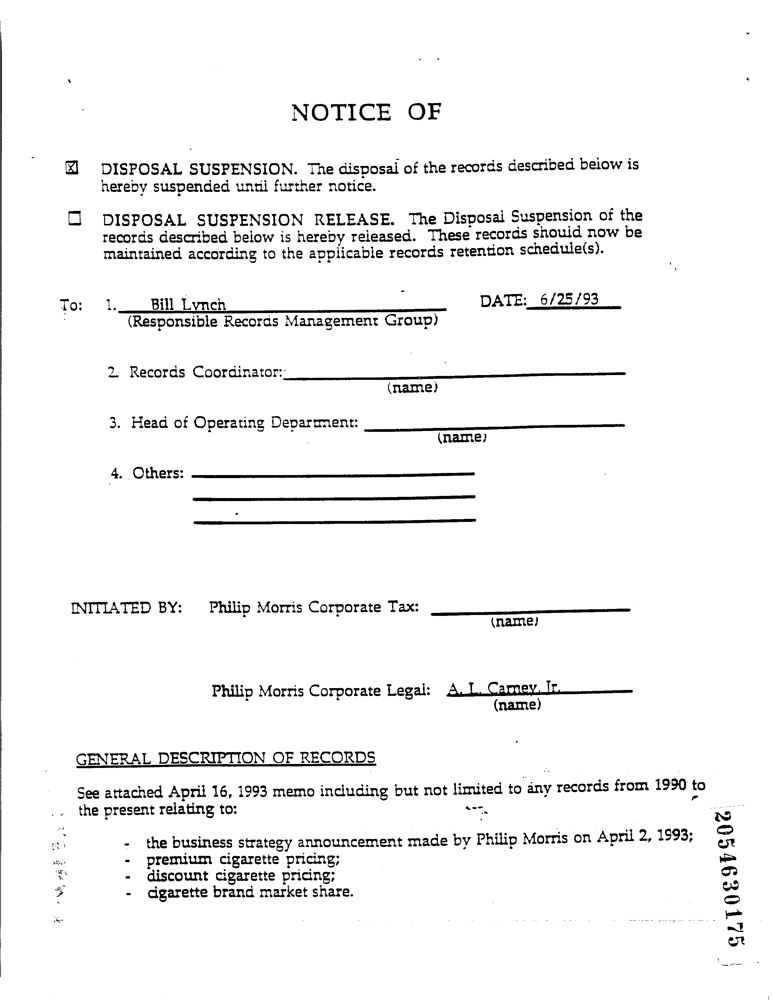


--- Explanation for Top Result (Rank #1) ---
{
  "value": 10.122459,
  "description": "script score function, computed with script:\"Script{type=inline, lang='painless', idOrCode='maxSimDotProduct(params.query_vector, 'colqwen_vectors')', options={}, params={query_vector=[...vector omitted for brevity...]}}\"",
  "details": []
}

Searching for: '인사팀에서 보내온 복리후생 정책 변경 안내문이 있나?'
🚀 Search Latency: 5472.47 ms


ID: 515799417 Score: 14.6176 Category: letter,ID: tcal0263198_3200 Score: 13.3207 Category: memo,ID: 0011897059 Score: 13.2962 Category: memo,ID: 2083318606b Score: 13.1714 Category: email,ID: 2072481221 Score: 13.0521 Category: email

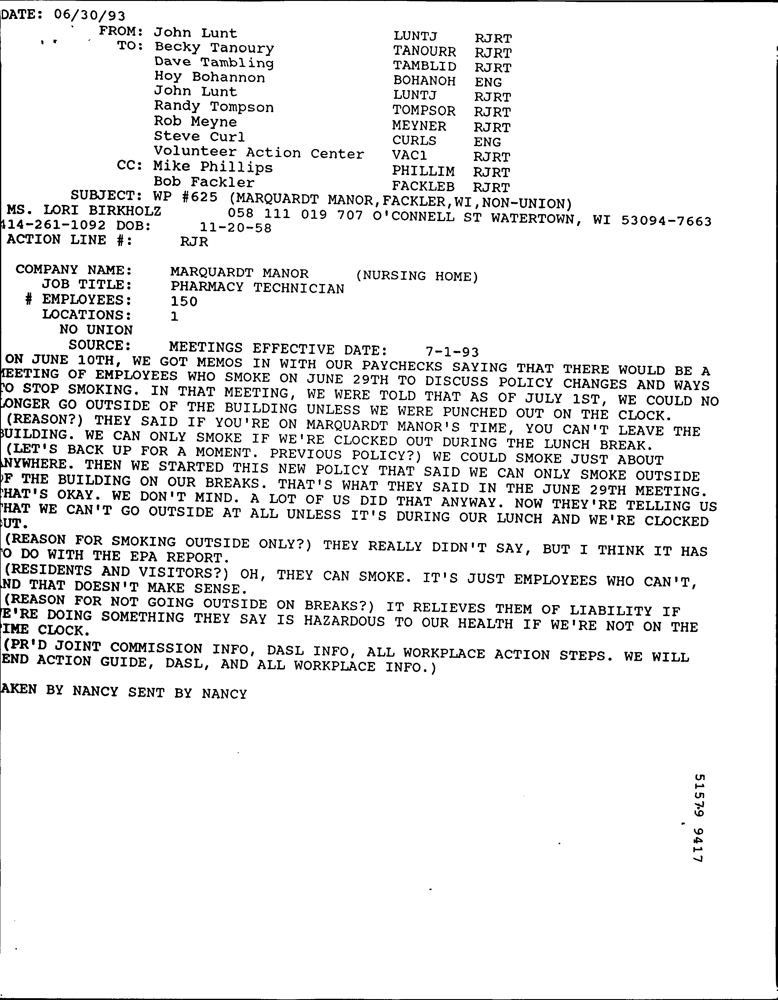
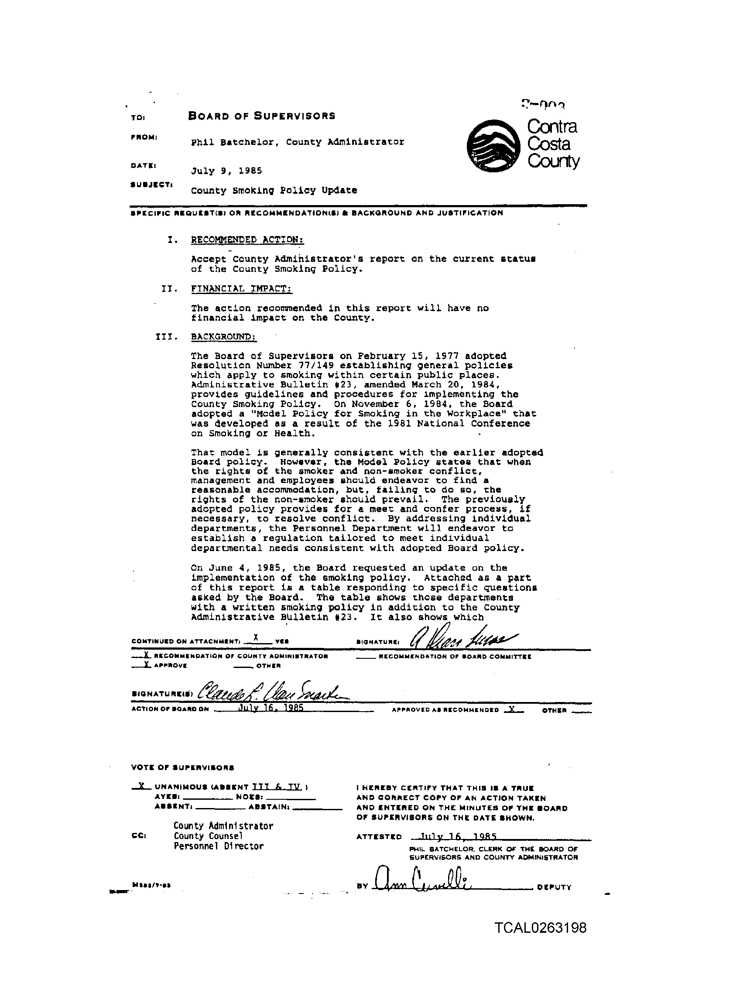
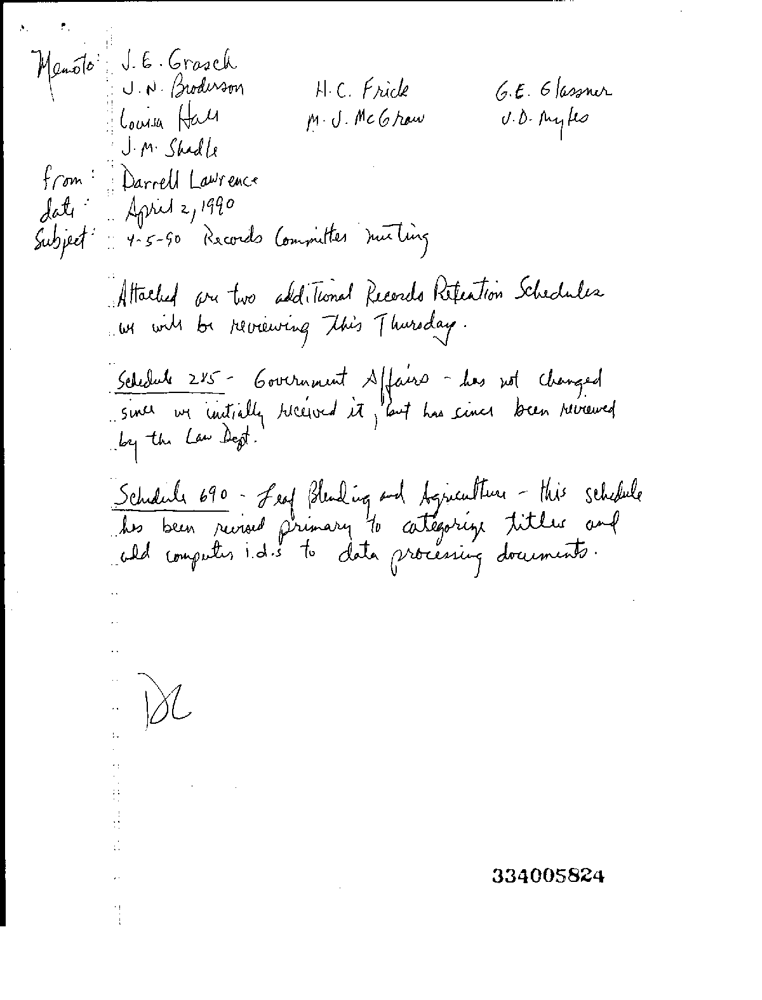
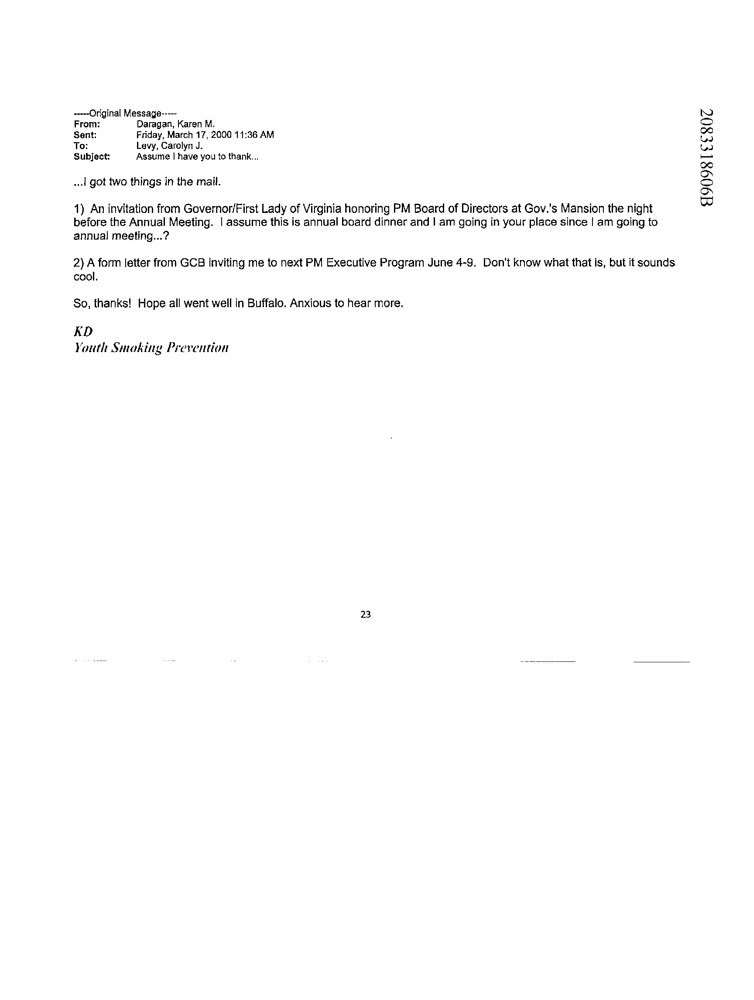
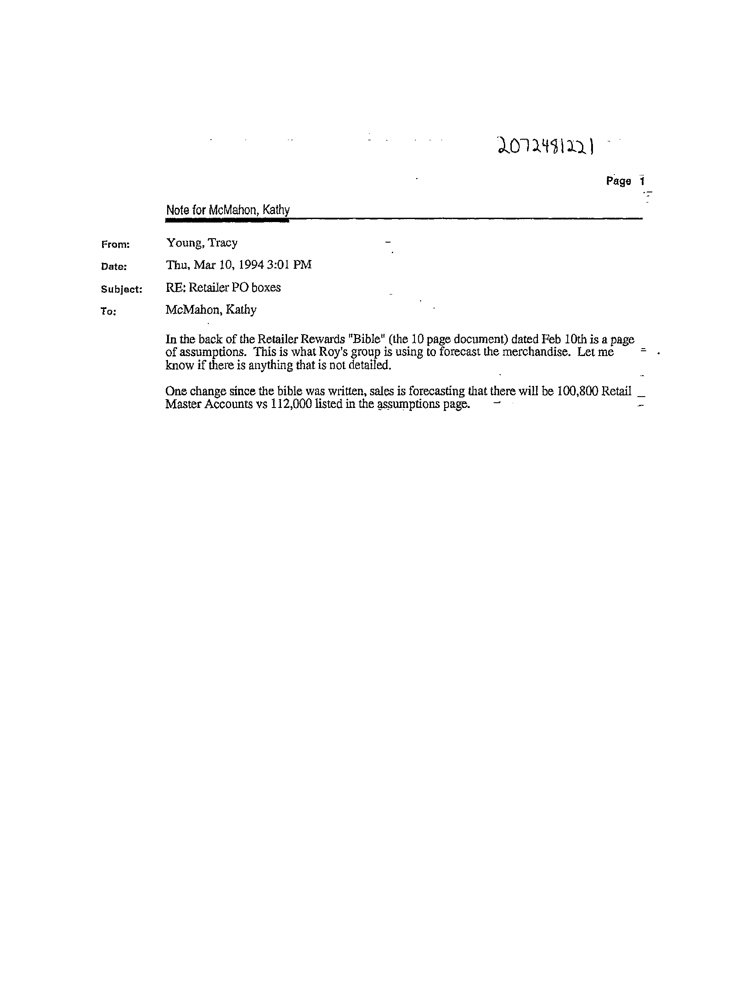


--- Explanation for Top Result (Rank #1) ---
{
  "value": 14.617598,
  "description": "script score function, computed with script:\"Script{type=inline, lang='painless', idOrCode='maxSimDotProduct(params.query_vector, 'colqwen_vectors')', options={}, params={query_vector=[...vector omitted for brevity...]}}\"",
  "details": []
}


In [7]:
# Add necessary libraries
import json
import re
import time

def remove_query_vector_from_explanation(explanation_obj):
    """
    Recursively traverses the explanation object to remove the lengthy 'query_vector' parameter
    from both structured 'params' and string-based 'description' fields.
    """
    if isinstance(explanation_obj, dict):
        if 'description' in explanation_obj and isinstance(explanation_obj['description'], str):
            explanation_obj['description'] = re.sub(
                r"query_vector=\[\[.*?\]\]", 
                "query_vector=[...vector omitted for brevity...]", 
                explanation_obj['description']
            )
        if 'params' in explanation_obj and 'query_vector' in explanation_obj['params']:
            explanation_obj['params']['query_vector'] = "[...vector omitted for brevity...]"
        for key, value in explanation_obj.items():
            remove_query_vector_from_explanation(value)
    elif isinstance(explanation_obj, list):
        for item in explanation_obj:
            remove_query_vector_from_explanation(item)
    return explanation_obj

def search_and_display_with_explain(query, es_client):
    print(f"\nSearching for: '{query}'")
    query_vectors = create_colqwen_query_vectors(query)
    
    # This is the original, full "late interaction" search query.
    es_query = {
        "_source": ["image_path", "category"],
        "query": {
            "script_score": {
                "query": {"match_all": {}},
                "script": {
                    "source": f"maxSimDotProduct(params.query_vector, '{VECTOR_FIELD_NAME}')",
                    "params": {"query_vector": query_vectors},
                },
            }
        },
        "size": 5,
        "explain": True  # Enable the Explain API
    }
    
    # --- Measure Search Latency ---
    start_time = time.time()
    results = es_client.search(index=INDEX_NAME, body=es_query)
    end_time = time.time()
    latency_ms = (end_time - start_time) * 1000
    print(f"🚀 Search Latency: {latency_ms:.2f} ms")
    # --- End of Measurement ---

    hits = results["hits"]["hits"]
    
    # --- Display visual results ---
    html = "<table><tr>"
    for hit in hits:
        doc_id = hit["_id"]
        score = hit["_score"]
        path = hit["_source"]["image_path"]
        category = hit["_source"]["category"]
        try:
            with open(path, "rb") as image_file:
                img_str = base64.b64encode(image_file.read()).decode()
                html += f"""
                <td style='text-align: center; vertical-align: top; padding: 10px; border: 1px solid #ddd;'>
                    <img src='data:image/png;base64,{img_str}' width='200'><br>
                    <b>ID:</b> {doc_id}<br>
                    <b>Score:</b> {score:.4f}<br>
                    <b>Category:</b> {category}
                </td>
                """
        except Exception as e:
            print(f"Could not display image {path}: {e}")
    html += "</tr></table>"
    
    if hits:
        display(HTML(html))
        
        # --- Display the cleaned explanation for the top result ---
        top_hit_explanation = hits[0].get("_explanation")
        if top_hit_explanation:
            print("\n--- Explanation for Top Result (Rank #1) ---")
            cleaned_explanation = remove_query_vector_from_explanation(top_hit_explanation)
            print(json.dumps(cleaned_explanation, indent=2))
            
    else:
        print("No results found.")

# Perform a series of searches to demonstrate the model's capabilities with explanations.
search_and_display_with_explain("Do you have a benefits policy change notice from HR?", es)
search_and_display_with_explain("인사팀에서 보내온 복리후생 정책 변경 안내문이 있나?", es)

### Step 8: Free up Memory

**[EN]** As a best practice, explicitly delete the model and processor to free up GPU or system memory after the demonstration is complete.<br>
**[KR]** 모델이 사용한 메모리를 해제하기 위해 커널을 강제로 종료합니다.

In [ ]:
del model
del processor

import gc

if 'torch' in locals() and torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("CUDA cache cleared.")
elif 'torch' in locals() and torch.backends.mps.is_available():
    torch.mps.empty_cache()
    print("MPS cache cleared.")

gc.collect()
print("Memory cleanup complete.")